In [1]:
import torch
from torch import nn 
from d2l import torch as d2l

In [2]:
 net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [3]:
X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shale: \t', X.shape)

Conv2d output shale: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shale: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shale: 	 torch.Size([1, 6, 14, 14])
Conv2d output shale: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shale: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shale: 	 torch.Size([1, 16, 5, 5])
Flatten output shale: 	 torch.Size([1, 400])
Linear output shale: 	 torch.Size([1, 120])
Sigmoid output shale: 	 torch.Size([1, 120])
Linear output shale: 	 torch.Size([1, 84])
Sigmoid output shale: 	 torch.Size([1, 84])
Linear output shale: 	 torch.Size([1, 10])


In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    # @save
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X),y), y.numel())
    return metric[0] / metric[1]

In [6]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    # @save
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(
        xlabel='epoch', xlim=[1,num_epochs],
        legend=['train loss', 'train acc', 'test acc']
    )
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat,y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches, (train_l,train_acc,None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None,None,test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (train_l, train_acc, test_acc))
    print('%.1f examples/sec on %s' % (metric[2]*num_epochs/timer.sum(), str(device)))


In [7]:
def try_mps():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

loss 0.465, train acc 0.825, test acc 0.783
5452.2 examples/sec on cpu


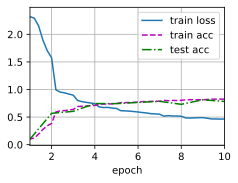

In [8]:
lr = 0.9
num_epochs = 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.460, train acc 0.828, test acc 0.820
28314.3 examples/sec on mps


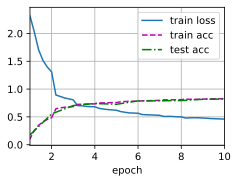

In [9]:
lr = 0.9
num_epochs = 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_mps())